# CNIT 484 Final Project #
## Financial Analysis ##

### Libraries ###
Add more as needed. Make sure to add to requirements.txt as well.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import math
from tempfile import TemporaryDirectory
import time
import os
from torch.optim.lr_scheduler import StepLR

## Loading Data ##

In [2]:
raw_data = pd.read_csv("../Datasets/1_ETHUSDT_1.1.2018-1.2.2024_1hour.csv", header=None)
print(raw_data.head())
print(raw_data.shape)


                    0       1       2       3       4           5   \
0  2017-12-31 19:00:00  733.01  734.52  720.03  727.62  2105.90100   
1  2017-12-31 20:00:00  727.01  732.00  716.80  717.97  2305.97086   
2  2017-12-31 21:00:00  717.67  725.75  717.59  724.05  2166.45725   
3  2017-12-31 22:00:00  723.95  737.99  722.70  734.50  2160.90450   
4  2017-12-31 23:00:00  734.99  744.98  730.01  744.82  2335.33705   

              6             7     8           9              10  11  
0  1514768399999  1.528559e+06  3114  1275.23271  925445.068280   0  
1  1514771999999  1.675753e+06  2875  1035.33513  753211.787422   0  
2  1514775599999  1.564151e+06  2957  1179.82843  851942.067625   0  
3  1514779199999  1.582200e+06  3647  1095.63271  801470.072777   0  
4  1514782799999  1.724788e+06  3512  1313.03081  970430.311743   0  
(53207, 12)


                       open    high     low   close      volume  next_close
date                                                                       
2017-12-31 19:00:00  733.01  734.52  720.03  727.62  2105.90100      717.97
2017-12-31 20:00:00  727.01  732.00  716.80  717.97  2305.97086      724.05
2017-12-31 21:00:00  717.67  725.75  717.59  724.05  2166.45725      734.50
2017-12-31 22:00:00  723.95  737.99  722.70  734.50  2160.90450      744.82
2017-12-31 23:00:00  734.99  744.98  730.01  744.82  2335.33705      748.99
(53206, 6)


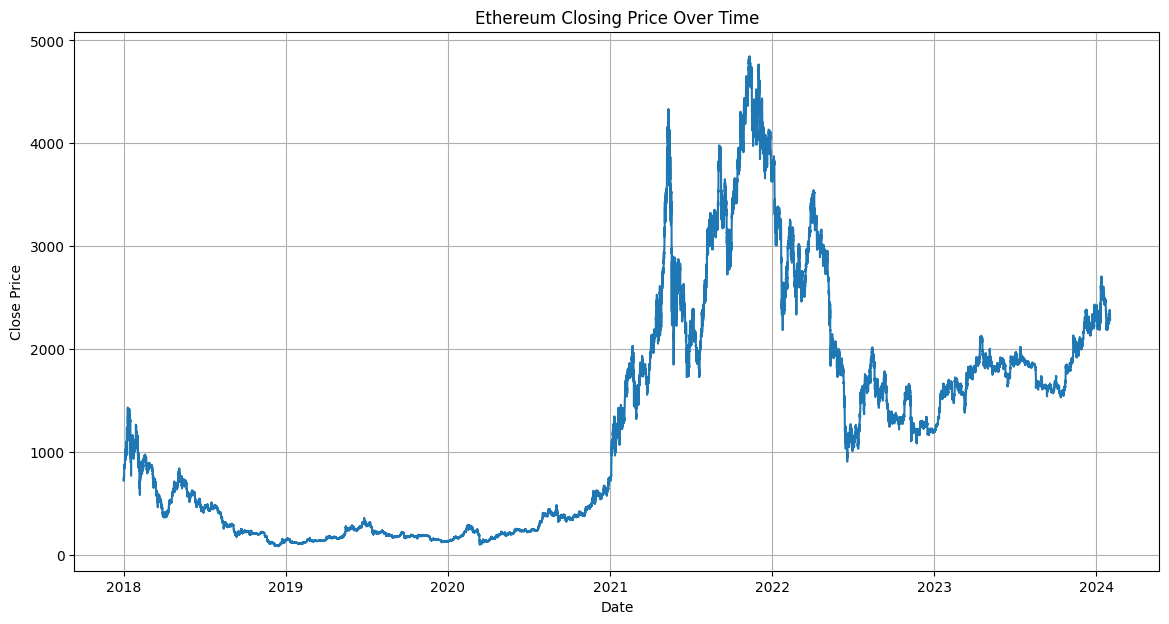

In [3]:
raw_data.columns = ['date', 'open', 'high', 'low', 'close', 'volume'] + list(raw_data.columns[6:])
raw_data.drop(raw_data.columns[6:], axis=1, inplace=True)

# Convert the 'date' column to datetime and make it the index
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.set_index('date', inplace=True)

raw_data['next_close'] = raw_data['close'].shift(-1)
#drop last value since itll be NaN
raw_data = raw_data.dropna()


print(raw_data.head())
print(raw_data.shape)

plt.figure(figsize=(14, 7))
plt.plot(raw_data['close'])
plt.title('Ethereum Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


## Preprocessing ##

#### Scaling ####

In [4]:
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(raw_data), columns=raw_data.columns, index=raw_data.index)

print(normalized_data.head())

                         open      high       low     close    volume  \
date                                                                    
2017-12-31 19:00:00  0.136596  0.136168  0.134327  0.135470  0.004270   
2017-12-31 20:00:00  0.135337  0.135641  0.133647  0.133444  0.004675   
2017-12-31 21:00:00  0.133377  0.134335  0.133813  0.134720  0.004392   
2017-12-31 22:00:00  0.134695  0.136893  0.134889  0.136914  0.004381   
2017-12-31 23:00:00  0.137012  0.138354  0.136427  0.139080  0.004735   

                     next_close  
date                             
2017-12-31 19:00:00    0.133444  
2017-12-31 20:00:00    0.134720  
2017-12-31 21:00:00    0.136914  
2017-12-31 22:00:00    0.139080  
2017-12-31 23:00:00    0.139955  


#### Sequencing ####

In [5]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets, seq_length):
        self.sequences = sequences
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return self.sequences.shape[0] - self.seq_length - 9  # Adjusted for 10 target values

    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index:index+self.seq_length].values, dtype=torch.float32)
        target = torch.tensor(self.targets[index:index+self.seq_length].values, dtype=torch.float32)
        # Expand the target tensor to match the model's output
        target = target.unsqueeze(-1).expand(-1, 10)
        return sequence, target

# Assuming 'data' is your DataFrame
features = normalized_data[['open', 'high', 'low', 'close', 'volume']]
targets = normalized_data['next_close']

# Define sequence length and create dataset
seq_length = 24
dataset = TimeSeriesDataset(features, targets, seq_length)


print(f"Number of sequences: {len(dataset)}")
print(f"Shape of sequences: {dataset[0][0].shape}")
print(normalized_data.head())

Number of sequences: 53173
Shape of sequences: torch.Size([24, 5])
                         open      high       low     close    volume  \
date                                                                    
2017-12-31 19:00:00  0.136596  0.136168  0.134327  0.135470  0.004270   
2017-12-31 20:00:00  0.135337  0.135641  0.133647  0.133444  0.004675   
2017-12-31 21:00:00  0.133377  0.134335  0.133813  0.134720  0.004392   
2017-12-31 22:00:00  0.134695  0.136893  0.134889  0.136914  0.004381   
2017-12-31 23:00:00  0.137012  0.138354  0.136427  0.139080  0.004735   

                     next_close  
date                             
2017-12-31 19:00:00    0.133444  
2017-12-31 20:00:00    0.134720  
2017-12-31 21:00:00    0.136914  
2017-12-31 22:00:00    0.139080  
2017-12-31 23:00:00    0.139955  
torch.Size([24, 10])


#### Feature Embedding ####

Perhaps add int the time based components...

### Define Model ###

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:  # If d_model is even
            pe[:, 1::2] = torch.cos(position * div_term)
        else:  # If d_model is odd
            pe[:, 1::2] = torch.cos(position * div_term)[:,:-1]  # Exclude the last column
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x) -> torch.Tensor:
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, ninp, nhead, nhid, nlayers, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=ninp, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        self.decoder = nn.Linear(ninp, 10)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

### Splitting and Loading Data ###

In [17]:
# Define the size of each split
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.15)
test_size = len(dataset) - train_size - val_size

# Split the data
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 24
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
model = TransformerModel(ninp=5, nhead=5, nhid=200, nlayers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



c:\Users\drejc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
def train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0.
    for i, (input, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Clear the gradients
        output = model(input)  # Forward pass
        loss = criterion(output.view(-1), target.view(-1))  # Reshape output and target to be 1D
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()  # Update the weights
        total_loss += loss.item()
    return total_loss / len(train_loader)

for epoch in range(10):  # Number of epochs
    loss = train(model, train_loader, criterion, optimizer)
    print(f"Epoch: {epoch}, Loss: {loss}")

In [ ]:
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            data, target = batch[:-1], batch[-1]
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(test_loader)

loss = evaluate(model, test_loader, criterion)
print(f"Test Loss: {loss}")